# Agriculture

In [ ]:
## Importing libraries
import panel as pn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import plotly.graph_objects as go
import plotly.express as px

pn.extension()


### State VS Crop
df = pd.read_csv("csv/State Vs Crop Production.csv")
pivot_df = df.pivot_table(index="State_Name", columns="Crop", values="Production", aggfunc="sum", fill_value=0)

# Selecting top 10 states and crops
# top_states = pivot_df.sum(axis=1).nlargest(10).index.tolist()
top_states = pivot_df.sum(axis=1).nlargest(11).index.tolist()  # Get top 11 to have a buffer
top_states = [state for state in top_states if state != "Andaman and Nicobar Islands"][:10]  # Remove and limit to 10

top_crops = pivot_df.sum(axis=0).nlargest(10).index.tolist()

#log transformation for better visualization
pivot_df = np.log1p(pivot_df.loc[top_states, top_crops])

# Widgets for selection
crop_selector = pn.widgets.CheckBoxGroup(name="Select Crops", options=top_crops, value=top_crops)
state_selector = pn.widgets.CheckBoxGroup(name="Select State", options=top_states, value=top_states)

# Function to plot the stacked bar chart
def plot_stacked_bar(selected_crops, selected_states):
    if not selected_crops or not selected_states:
        return "Please select at least one Crop and one State."

    filtered_df = pivot_df.loc[selected_states, selected_crops]

    fig, ax = plt.subplots(figsize=(8, 6))
    filtered_df.plot(kind="bar", stacked=True, ax=ax, colormap="viridis")
    
    ax.set_title("Top 10 States by Crop Production", fontsize=14, fontweight="bold")
    ax.set_ylabel("Production (log scale)", fontsize=12)
    ax.set_xlabel("State", fontsize=12)
    ax.legend(title="Crops", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

interactive_plot = pn.bind(plot_stacked_bar, crop_selector, state_selector)



### KCC Query Analysis
df2 = pd.read_csv("csv/Gujarat.csv")

if "QueryType" not in df2.columns:
    raise ValueError("Column 'QueryType' not found in the dataset!")

sns.set_style("whitegrid")
plt.style.use("ggplot")

query_counts = df2["QueryType"].value_counts()
N = 10
top_n_query_types = query_counts.nlargest(N).index.tolist()

top_n_data = df2[df2["QueryType"].isin(top_n_query_types)]["QueryType"].value_counts().reset_index()
top_n_data.columns = ["QueryType", "Count"]

checkboxes = pn.widgets.CheckBoxGroup(
    name="Select Query Types", options=top_n_query_types, value=top_n_query_types
)

def plot_pie_chart(selected_options):
    filtered_data = top_n_data[top_n_data["QueryType"].isin(selected_options)]
    
    if filtered_data.empty:
        return plt.figure(figsize=(8, 5))
    
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = sns.color_palette("pastel", len(filtered_data))
    
    wedges, _ = ax.pie(
        filtered_data["Count"],
        colors=colors,
        wedgeprops={"edgecolor": "black", "linewidth": 1, "antialiased": True}
    )
    
    ax.legend(
        wedges, filtered_data["QueryType"], 
        title="Query Types", 
        loc="center left", 
        bbox_to_anchor=(1, 0.5),
        fontsize=10,
        frameon=True
    )
    
    plt.title("Query Types in Kisan Call Centre Scheme", fontsize=14, fontweight="bold")
    return fig

pie_chart_pane = pn.bind(plot_pie_chart, checkboxes)

# Define Agriculture Page with improved UI

def get_agriculture_page():
    return pn.Column(
        pn.pane.HTML("<h1 style='font-size:60px; font-weight:bold; color:green;'>🌾 Agriculture Data Analysis</h1>"),
        pn.pane.Markdown("# State V/S Crop Production", sizing_mode='stretch_width'),
        pn.pane.Markdown("### The stacked bar chart showcases the crop production distribution across the top 10 states, highlighting key crops like Rice, Wheat, Sugarcane, and Cotton. ", sizing_mode='stretch_width'),
        pn.pane.Markdown("### Select Crops and States:", sizing_mode='stretch_width'),

        # Row for crop selector, state selector, and interactive plot
        pn.Row(
            pn.Column(
                pn.pane.Markdown("#### Crops", sizing_mode="stretch_width"),
                crop_selector,
                width=120
            ),

            pn.Column(
                pn.pane.Markdown("#### States", sizing_mode="stretch_width"),
                state_selector,
                width=120
            ),
            pn.Column(interactive_plot, sizing_mode="stretch_width"),
            sizing_mode="stretch_width"
        ),

        pn.pane.Markdown("# Kisan Call Centre - Type Of Queries", sizing_mode='stretch_width'),
         pn.pane.Markdown("### The below Pie Chart shows the Types of Queries raised by the people under KCC Scheme. ", sizing_mode='stretch_width'),
        pn.pane.Markdown("### Select Query Types to Update Pie Chart", sizing_mode='stretch_width'),

        # Row for checkboxes and pie chart (Reduced spacing)
        pn.Row(
            pn.Column(checkboxes, width=150),
            pn.Column(pie_chart_pane, width=200),
            sizing_mode="stretch_width"
        ),

        # Back to Home button
        pn.Row(
            pn.Spacer(height=10),
            pn.widgets.Button(name="Back to Home", button_type="primary", on_click=lambda event: switch_page(event, "home")),
            sizing_mode='stretch_width'
        ),

        sizing_mode='stretch_width',
        css_classes=['agriculture-page']
    )

print("Agriculture page working successfully!")

Agriculture page working successfully!


# Education

In [ ]:

pn.extension()  # Initialize Panel

# Load Data for Education Schemes
df_edu = pd.read_csv("csv/Education_Schemes.csv")

# Extract unique schemes and years
unique_schemes = df_edu["Scheme_Name"].dropna().unique().tolist()
years = sorted([year for year in df_edu["Year.1"].dropna().astype(int).unique() if 2013 <= year <= 2023])

# Panel checkboxes for interactivity
scheme_selector = pn.widgets.CheckBoxGroup(name="Select Schemes", options=unique_schemes[:10], value=unique_schemes[:5])
year_selector = pn.widgets.CheckBoxGroup(name="Select Years", options=years, value=years[-8:])  # Select last 8 years by default

# Function to update grouped bar chart dynamically
def plot_chart(selected_schemes, selected_years):
    df_filtered = df_edu[(df_edu["Scheme_Name"].isin(selected_schemes)) & 
                          (df_edu["Year.1"].isin(selected_years))]

    # Pivot table for visualization
    df_pivot = df_filtered.pivot_table(index="Scheme_Name", columns="Year.1", values="No_of_Students_Benefited", aggfunc="sum")

    # If no data is selected, return a blank figure
    if df_pivot.empty:
        return plt.figure(figsize=(8, 6))

    # Plot the grouped bar chart
    fig, ax = plt.subplots(figsize=(8, 6))  # Set size to 8x5
    df_pivot.plot(kind="bar", ax=ax, colormap="tab10", width=0.7, edgecolor="black")

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

    plt.xlabel("Education Schemes", fontsize=10, fontweight="bold")
    plt.ylabel("Number of Students Benefited (in Thousands)", fontsize=10, fontweight="bold")
    plt.title("Education Schemes - Students Enrolled Over the Years", fontsize=11, fontweight="bold")

    plt.xticks(rotation=30, fontsize=8, ha="right")  # Adjust x-axis labels
    plt.subplots_adjust(bottom=0.3)  # Increase bottom margin for full labels

    plt.legend(title="Year", fontsize=8)
    plt.grid(True, linestyle="--", alpha=0.7)

    return fig  # Return the plot

# *State GDP Analysis (for Education)*
df_gdp = pd.read_csv("csv/State_GDP_Education.csv")

df_gdp["Year"] = df_gdp["Year"].astype(int)

df_grouped_gdp = df_gdp.groupby(["State"])["GDP_Education_Percentage"].mean().reset_index()


max_gdp = df_grouped_gdp["GDP_Education_Percentage"].max()

# Panel Widgets for GDP
state_selector = pn.widgets.CheckBoxGroup(name="Select States", options=list(df_gdp["State"].unique()), value=list(df_gdp["State"].unique())[:5])
gdp_range = pn.widgets.RangeSlider(name="Select GDP Percentage Range", start=0, end=max_gdp, value=(0, max_gdp), step=0.1)


def plot_pie_chart(selected_states, gdp_range_values):
    df_filtered = df_grouped_gdp[
        (df_grouped_gdp["State"].isin(selected_states)) & 
        (df_grouped_gdp["GDP_Education_Percentage"].between(*gdp_range_values))
    ]

    if df_filtered.empty:
        return plt.figure(figsize=(8, 5))

    fig, ax = plt.subplots(figsize=(8, 5))
    num_states = len(df_filtered)

    # Generate unique colors dynamically
    cmap = plt.get_cmap("tab20")  # Using 'tab20' for more color variations
    colors = [cmap(i / num_states) for i in range(num_states)]  

    wedges, _ = ax.pie(
        df_filtered["GDP_Education_Percentage"], 
        colors=colors, 
        startangle=140,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding border
    )

    legend_labels = [f"{state}: {gdp:.1f}%" for state, gdp in zip(df_filtered["State"], df_filtered["GDP_Education_Percentage"])]
    ax.legend(wedges, legend_labels, title="States & GDP %", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

    plt.title("GDP Percentage Spent on Education", fontsize=12, fontweight="bold")

    return fig


# *Create the Education Page Layout*
def get_education_page():
    print("📌 Education page function called!")  # Debugging print

    return pn.Column(
        pn.pane.HTML("<h1 style='font-size:50px; font-weight:bold; color:brown;'>📚 Education Data Analysis</h1>"),
        pn.pane.Markdown("# Student Benefited by Schemes", sizing_mode='stretch_width'),
        pn.pane.Markdown("### Below given graphs shows the number of students benefited under Schemes over the years."),
        pn.Column(
                pn.pane.Markdown("#### Scheme", sizing_mode="stretch_width"),
                scheme_selector,
                width=250
                ),
        pn.Spacer(height=20),
        pn.Row( pn.Column(
                pn.pane.Markdown("#### Year", sizing_mode="stretch_width"),
                year_selector,
                width=200
                ),
               pn.pane.Matplotlib(pn.bind(plot_chart, scheme_selector, year_selector))),
        
        pn.pane.Markdown("# State GDP spent for Education", sizing_mode='stretch_width'),
        pn.pane.Markdown("### Below given pie chart shows the the GDP percentage spent by States on Education."),
        pn.pane.Markdown("### Select States"),
        pn.Row(
            pn.Column(state_selector, width=100),
            pn.pane.Matplotlib(pn.bind(plot_pie_chart, state_selector, gdp_range))
        ),
        

        pn.Row(
            pn.Spacer(height=10),
            pn.widgets.Button(name="Back to Home", button_type="primary", on_click=lambda event: switch_page(event, "home")),
            sizing_mode='stretch_width'
        ),
    )

print("Education page working successfully!")

Education page working successfully!


# Environment

Environment page working successfully!


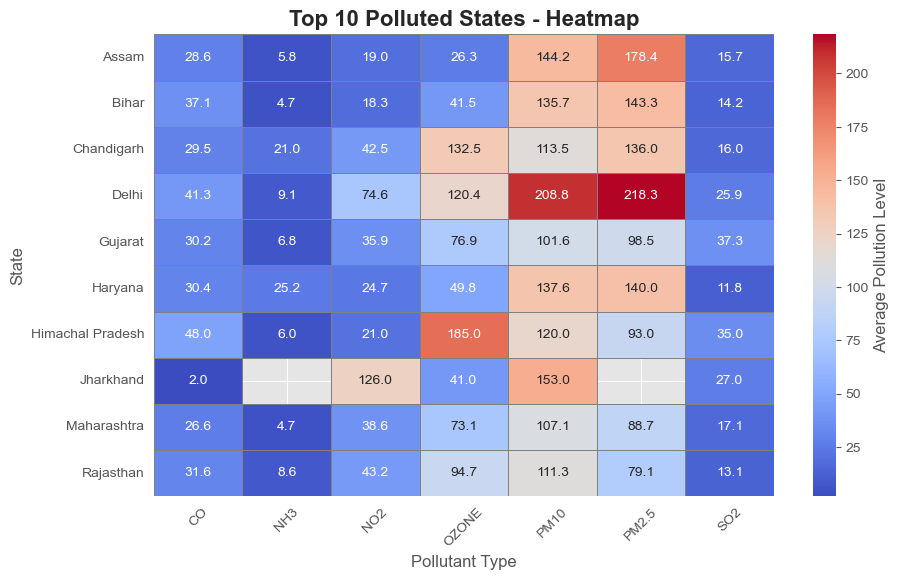

In [ ]:
# Load Pollutant Data
df3 = pd.read_csv("csv/Pollutant and State.csv")

# For the top 10 states with highest average pollution levels
# .index only takes the state names in top_10_states
top_10_states = df3.groupby("state")["pollutant_avg"].mean().nlargest(10).index

# Filter data for only the top 10 states
filtered_data = df3[df3["state"].isin(top_10_states)]

# Pivot is basically reshaping a table for us 
heatmap_data_filtered = filtered_data.pivot_table(index="state", columns="pollutant_id", values="pollutant_avg")

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_filtered, 
            cmap="coolwarm", 
            # annot basically show value of pollutant level
            annot=True, 
            fmt=".1f", 
            linewidths=0.5, 
            linecolor='gray', 
            # cbar_kws is basically adding color bar for the range.
            cbar_kws={'label': 'Average Pollution Level'})

plt.title("Top 10 Polluted States - Heatmap", fontsize=16, fontweight="bold")
plt.xlabel("Pollutant Type", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
heatmap_pane = pn.pane.Matplotlib(plt.gcf(), tight=True) # Wrap heatmap figure

# Load Temperature Data
df4 = pd.read_csv("csv/Annual Temperature.csv")
df_temp_cleaned = df4.dropna()

# Converts ANNUAL to numeric type and incase if there is non numeric then replace it by coerce which is nan
df_temp_cleaned.loc[:, "ANNUAL"] = pd.to_numeric(df_temp_cleaned["ANNUAL"], errors="coerce")
df_temp_cleaned = df_temp_cleaned.dropna()

# Define a function to update the plot based on rolling window size
def plot_rolling_avg(window_size):
    # in rolling map  window=window_size defines the number of year for averaging and min_period says that it should be minimum 1
    # mean takes the mean of the year's ANNUAL we have 
    df_temp_cleaned.loc[:, "Rolling_Avg"] = df_temp_cleaned["ANNUAL"].rolling(window=window_size, min_periods=1).mean()

    plt.figure(figsize=(10, 5))
    plt.plot(df_temp_cleaned["YEAR"], df_temp_cleaned["ANNUAL"], label="Annual Temperature", alpha=0.5)
    plt.plot(df_temp_cleaned["YEAR"], df_temp_cleaned["Rolling_Avg"], label=f"{window_size}-Year Rolling Average", color="blue", linewidth=2)
    
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Annual Mean Temperature with {window_size}-Year Rolling Average")
    plt.legend()
    plt.grid(True)
    
    return pn.pane.Matplotlib(plt.gcf(), tight=True)

# Create a Panel slider widget by default 10
window_slider = pn.widgets.IntSlider(name="Rolling Window Size", start=1, end=50, step=1, value=10)

# Create an interactive panel
interactive = pn.bind(plot_rolling_avg, window_slider)

# Layout the dashboard
def get_environment_page():
    return pn.Column(
        pn.pane.HTML("<h1 style='font-size:50px; font-weight:bold; color:blue;'>🌍 Environment Data Analysis</h1>"),
        pn.pane.Markdown("## State-Pollutant Pollution Level", sizing_mode='stretch_width'),
        pn.pane.Markdown("### The below Heat Map Describes the Pollutant's Pollution range over states. ", sizing_mode='stretch_width'),
        pn.Spacer(height=10),
        pn.Row(heatmap_pane, sizing_mode='stretch_width', width=700),  # Wrapped in a row for flex layout
        pn.Spacer(height=20),
        pn.pane.Markdown("## Annual Temperature Change Over Years"),
        pn.pane.Markdown("### The below Rolling Average Map shows the change in temperature over years. ", sizing_mode='stretch_width'),
        "Adjust the rolling window size using the slider below:",
        pn.Row(
            pn.Column(window_slider, width=250),
            pn.Column(interactive, sizing_mode='stretch_width', width=700),
            sizing_mode='stretch_width'
        ),
        pn.Row(
            pn.Spacer(height=10),
            pn.widgets.Button(name="Back to Home", button_type="primary", on_click=lambda event: switch_page(event, "home")),
            sizing_mode='stretch_width'
        ),
    )

print("Environment page working successfully!")

# Economics

In [ ]:
df7 = pd.read_csv("csv/Union_Budget.csv")

# this is for getting the different values and then converting them into null and replacing null by mean
num_cols = [
    "Actuals 2021-2022 Revenue", "Actuals 2021-2022 Capital", "Actuals 2021-2022 Total",
    "Budget Estimates 2022-2023 Revenue", "Budget Estimates 2022-2023 Capital", "Budget Estimates 2022-2023 Total",
    "Revised Estimates2022-2023 Revenue", "Revised Estimates 2022-2023 Capital", "Revised Estimates2022-2023 Total",
    "Budget Estimates2023-2024 Revenue", "Budget Estimates2023-2024 Capital", "Budget Estimates2023-2024 Total"
]

# Convert to numeric (if not already) and replace missing values with column mean
# Convert non-numeric to NaN
df7[num_cols] = df7[num_cols].apply(pd.to_numeric, errors='coerce')  
df7[num_cols] = df7[num_cols].fillna(df7[num_cols].mean()) 

In [ ]:
## Revenue Capital
 
years = ["2021-2022", "2022-2023 (BE)", "2022-2023 (RE)", "2023-2024 (BE)"]
revenue_values = [
    df7["Actuals 2021-2022 Revenue"].sum(),
    df7["Budget Estimates 2022-2023 Revenue"].sum(),
    df7["Revised Estimates2022-2023 Revenue"].sum(),
    df7["Budget Estimates2023-2024 Revenue"].sum()
]
capital_values = [
    df7["Actuals 2021-2022 Capital"].sum(),
    df7["Budget Estimates 2022-2023 Capital"].sum(),
    df7["Revised Estimates 2022-2023 Capital"].sum(),
    df7["Budget Estimates2023-2024 Capital"].sum()
]
fig = go.Figure()
pn.extension("plotly")

# Add Revenue
fig.add_trace(go.Waterfall(
    name="Revenue",
    x=years,
    y=revenue_values,
    measure=["relative"] * len(years),
    text=revenue_values,
    textposition="outside",
    connector={"line": {"color": "blue"}},
    increasing={"marker": {"color": "blue"}}
))

# Add Capital
fig.add_trace(go.Waterfall(
    name="Capital",
    x=years,
    y=capital_values,
    measure=["relative"] * len(years),
    text=capital_values,
    textposition="outside",
    connector={"line": {"color": "red"}},
    increasing={"marker": {"color": "red"}}
))

# Customize layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Amount (in Crores)",
    showlegend=True,
    width=1000,  # Adjust the width (increase for a larger graph)
    height=800 
)


## Ministry wise budget
df8 = pd.read_csv("csv/Union_Budget.csv")

# Handling missing values (if any)
df8.fillna(0, inplace=True)

# Creating a new column for Total Budget Allocation
df8["Total Budget 2023-2024"] = df8["Budget Estimates2023-2024 Revenue"] + df8["Budget Estimates2023-2024 Capital"]

# Creating the Treemap without a root (avoiding grand total)
fig2 = px.treemap(
    df8, 
    path=[px.Constant("Ministry-Wise Budget"), "Ministry/Department"],  # Adds a virtual root to avoid full rectangle
    values="Total Budget 2023-2024",  # Size based on total budget
    color="Total Budget 2023-2024",  # Color by budget allocation
    color_continuous_scale="blues",
)

fig2.update_layout(
    width=1000,  # Adjust the width (increase for a larger graph)
    height=700   # Adjust the height
)
fig2.update_traces(root_color="white") 
def get_statistic_page():
    # Convert Plotly figures to Panel objects
    revenue_capital_chart = pn.pane.Plotly(fig)  # Waterfall Chart
    ministry_budget_chart = pn.pane.Plotly(fig2)  # Treemap Chart

    return pn.Column(
        pn.pane.HTML("<h1 style='font-size:50px; font-weight:bold; color:purple;'>💸 Economics Data Analysis</h1>"),
        pn.pane.Markdown("## Revenue V/S Capital Allocation", sizing_mode='stretch_width'),
        pn.pane.Markdown("### The below graph shows the capital invested and revenue generated. ", sizing_mode='stretch_width'),
        revenue_capital_chart,  # Display Waterfall Chart
        pn.pane.Markdown("## Ministry-Wise Budget Allocation (2023-2024)", sizing_mode='stretch_width'),
        pn.pane.Markdown("### The provided Tree Map shows the budget allocation Ministry wise. ", sizing_mode='stretch_width'),
        ministry_budget_chart,  # Display Treemap Chart
        pn.Row(
            pn.Spacer(height=10),
            pn.widgets.Button(name="Back to Home", button_type="primary", on_click=lambda event: switch_page(event, "home")),
            sizing_mode='stretch_width'
        ),
    )
print("Economics page working successfully!")

Economics page working successfully!


In [9]:
import panel as pn

pn.extension()

# Custom Styling
button_css = {
    "width": "180px", "height": "50px", "font-size": "20px",
    "margin": "10px", "border-radius": "8px", "font-weight": "bold"
}
title_css = {"font-size": "26px", "font-weight": "bold", "margin-bottom": "20px"}
description_css = {"font-size": "14px", "color": "#555", "margin-bottom": "10px"}

# Define navigation buttons with better spacing
agri_btn = pn.widgets.Button(name="🌾 Agriculture", button_type="success", styles=button_css)
edu_btn = pn.widgets.Button(name="📚 Education", button_type="warning", styles=button_css)
env_btn = pn.widgets.Button(name="🌍 Environment", button_type="danger", styles=button_css)
stat_btn = pn.widgets.Button(name="💸 Economics", button_type="primary", styles=button_css)

# Function to switch pages
def switch_page(event, page=None):
    main_area.clear()  # Clear current page before adding new content

    if page == "agriculture" or event.obj.name == "🌾 Agriculture":
        main_area.append(get_agriculture_page())
    elif page == "home" or event.obj.name == "🏠 Home":
        main_area.append(homepage())
    elif page == "education" or event.obj.name == "📚 Education":
        main_area.append(get_education_page())
    elif page == "environment" or event.obj.name == "🌍 Environment":
        main_area.append(get_environment_page())
    elif page == "statistics" or event.obj.name == "💸 Economics":
        main_area.append(get_statistic_page())

# Attach event listeners
for btn in [agri_btn, edu_btn, env_btn, stat_btn]:
    btn.on_click(switch_page)

# Define homepage layout with a better structure
def homepage():
    return pn.Card(
        pn.Column(
            pn.pane.Markdown("# 📊 Public Sector Data Analysis", styles=title_css),
            pn.pane.Markdown("Explore different domains using the buttons below:", styles=description_css),
            pn.layout.Divider(),
            pn.Row(agri_btn, edu_btn, env_btn, stat_btn, align="center", styles={"margin-bottom": "20px"}),
            pn.layout.Divider(),
            pn.pane.Markdown("### 🌾 Agriculture", styles={"font-size": "18px", "font-weight": "bold"}),
            pn.pane.Markdown(
                "Agriculture sustains global food production and economies. Data analysis helps optimize crop yields, "
                "monitor soil health, and improve farming efficiency. Visualization aids in decision-making, enhancing sustainability and food security.",
                styles=description_css
            ),
            pn.layout.Divider(),
            pn.pane.Markdown("### 📚 Education", styles={"font-size": "18px", "font-weight": "bold"}),
            pn.pane.Markdown(
                "Education shapes society by imparting knowledge and skills. Data-driven insights help improve student performance, "
                "track literacy rates, and enhance learning methods, making education more effective and inclusive.",
                styles=description_css
            ),
            pn.layout.Divider(),
            pn.pane.Markdown("### 🌍 Environment", styles={"font-size": "18px", "font-weight": "bold"}),
            pn.pane.Markdown(
                "The environment includes natural resources and ecosystems. Data analysis tracks pollution, climate change, "
                "and conservation efforts, supporting sustainability and policy decisions through clear visual insights.",
                styles=description_css
            ),
            pn.layout.Divider(),
            pn.pane.Markdown("### 💸 Economics", styles={"font-size": "18px", "font-weight": "bold"}),
            pn.pane.Markdown(
                "Economics studies resource allocation, markets, and financial systems. Data visualization simplifies complex "
                "trends like GDP, inflation, and trade, helping policymakers and businesses make informed decisions.",
                styles=description_css
            ),
        ),
        title="Dashboard Home",
        styles={
            "padding": "25px", "background-color": "#ffffff", "border-radius": "12px", "box-shadow": "0px 4px 8px rgba(0, 0, 0, 0.1)"
        }
    )

# Main content area
main_area = pn.Column(homepage(), styles={"padding": "20px"})

# Final dashboard layout without the navigation sidebar
dashboard = main_area

# Show dashboard
dashboard.show()

Launching server at http://localhost:62620


AssertionError: 